In [24]:
import logging


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

In [25]:
from src.datasets.dataset import CnnDataset
from src.datasets.mnist_dataset import MiniMNISTDataset
from src.models.cnn import CNNParams, ConvLayerParams, ConvParams
from src.models.compression.enums import Activation, NNParamsCompMode, QMode
from src.models.eval import NNArchitectureEvaluator
from src.models.mlp import FCLayerParams, FCParams
from src.models.nn import ActivationParams, NNTrainParams


def get_LeNet5_params(
    DatasetClass: type[CnnDataset],
    conv_compression: NNParamsCompMode = NNParamsCompMode.NONE,
    conv_bitwidth: int = 8,
    conv_activation: ActivationParams = ActivationParams(Activation.NONE),
    fc_compression: NNParamsCompMode = NNParamsCompMode.NONE,
    fc_bitwidth: int = 8,
    fc_activation: ActivationParams = ActivationParams(Activation.NONE),
    epochs: int = 1,
    early_stop_patience: int = 10,
) -> CNNParams:
    cnn_train_loader, cnn_test_loader = DatasetClass.get_dataloaders(50)

    conv_params = ConvParams(
        in_channels=DatasetClass.input_channels,
        in_dimensions=DatasetClass.input_dimensions,
        in_bitwidth=8,
        out_height=DatasetClass.output_size,
        layers=[
            ConvLayerParams(
                channels=32, kernel_size=5, stride=1, pooling_kernel_size=2, compression=conv_compression, bitwidth=conv_bitwidth
            ),
            ConvLayerParams(
                channels=64, kernel_size=5, stride=1, pooling_kernel_size=2, compression=conv_compression, bitwidth=conv_bitwidth
            ),
        ],
        reste_threshold=1.5,
        reste_o=3,
        activation=conv_activation,
        dropout_rate=0.1,
    )
    cnn_fc_params = FCParams(
        layers=[
            FCLayerParams(512, fc_compression, bitwidth=fc_bitwidth),
            FCLayerParams(DatasetClass.output_size, fc_compression, bitwidth=fc_bitwidth),
        ],
        activation=fc_activation,
        qmode=QMode.DET,
        dropout_rate=0.0,
    )
    cnn_train_params = NNTrainParams(
        DatasetClass,
        cnn_train_loader,
        cnn_test_loader,
        epochs=epochs,
        learning_rate=0.001,
        weight_decay=0.00001,
        early_stop_patience=early_stop_patience,
    )
    cnn_params = CNNParams(
        in_bitwidth=8,
        conv=conv_params,
        fc=cnn_fc_params,
        train=cnn_train_params,
    )
    return cnn_params

In [26]:
params = get_LeNet5_params(
            DatasetClass=MiniMNISTDataset,
            conv_compression=NNParamsCompMode.NONE,
            conv_activation=ActivationParams(Activation.NONE),
            fc_compression=NNParamsCompMode.NONE,
            fc_activation=ActivationParams(Activation.NONE),
        )
model = params.get_model()
model.inspect_conv_layers()

INFO: Inspecting convolutional layers...
INFO: Input shape: torch.Size([1, 1, 28, 28]), equating to 784 inputs
INFO: Next layer shape: torch.Size([1, 32, 12, 12]), equating to 4608 inputs
INFO: Next layer shape: torch.Size([1, 64, 4, 4]), equating to 1024 inputs
INFO: FC input size is 1024


In [ ]:
from src.datasets.mnist_dataset import MiniMNISTDataset


def evaluate_architecture(
    compression: NNParamsCompMode,
    activation: Activation,
) -> dict | None:
    print(f"Evaluating LeNet5 with {compression} and {activation}...")

    model_params = get_LeNet5_params(
        DatasetClass=MiniMNISTDataset,
        conv_compression=compression,
        conv_activation=ActivationParams(activation),
        fc_compression=NNParamsCompMode.NONE,
        fc_activation=ActivationParams(activation),
    )
    evaluator = NNArchitectureEvaluator(model_params.train)

    try:
        stats = evaluator.evaluate_accuracy(model_params, times=1)
    except Exception as e:
        logging.error(f"Error evaluating {compression} with {activation}: {e}")
        return None

    return {
        "architecture": "LeNet5",
        "dataset": MiniMNISTDataset.__name__,
        "compression": compression,
        "activation": activation,
        "top-1": stats["max"],
        "mean": stats["mean"],
        "accuracies": stats["accuracies"],
    }


datapoints = []


for activation in Activation:
    for compression in NNParamsCompMode:
        if compression != NNParamsCompMode.TERNARY:
            continue

        res = evaluate_architecture(compression, activation)
        if res is None:
            continue

        datapoints.append(res)

Evaluating LeNet5 with NNParamsCompMode.TERNARY and Activation.NONE...
Evaluating LeNet5 with NNParamsCompMode.TERNARY and Activation.BINARIZE...


KeyboardInterrupt: 

In [28]:
datapoints

[{'architecture': 'LeNet5',
  'dataset': 'MNISTDataset',
  'compression': <NNParamsCompMode.TERNARY: 'ternary'>,
  'activation': <Activation.NONE: 'none'>,
  'top-1': 97.69285714285714,
  'mean': np.float64(97.29428571428572),
  'accuracies': [97.13571428571429,
   97.12142857142857,
   97.12857142857143,
   97.39285714285714,
   97.69285714285714]}]

In [ ]:
data = []
for dp in datapoints:
    for acc in dp["accuracies"]:
        data.append(
            {
                "compression": dp["compression"].name,
                "activation": dp["activation"].name,
                "accuracy": acc,
            }
        )

data

[{'compression': 'TERNARY', 'activation': 'NONE', 'accuracy': 94.25},
 {'compression': 'TERNARY', 'activation': 'NONE', 'accuracy': 94.25},
 {'compression': 'TERNARY', 'activation': 'NONE', 'accuracy': 94.75},
 {'compression': 'TERNARY', 'activation': 'NONE', 'accuracy': 91.25},
 {'compression': 'TERNARY', 'activation': 'NONE', 'accuracy': 93.875},
 {'compression': 'TERNARY', 'activation': 'BINARIZE', 'accuracy': 90.125},
 {'compression': 'TERNARY', 'activation': 'BINARIZE', 'accuracy': 92.125},
 {'compression': 'TERNARY', 'activation': 'BINARIZE', 'accuracy': 92.25},
 {'compression': 'TERNARY', 'activation': 'BINARIZE', 'accuracy': 89.875},
 {'compression': 'TERNARY', 'activation': 'BINARIZE', 'accuracy': 87.5},
 {'compression': 'TERNARY', 'activation': 'BINARIZE_RESTE', 'accuracy': 89.75},
 {'compression': 'TERNARY', 'activation': 'BINARIZE_RESTE', 'accuracy': 91.0},
 {'compression': 'TERNARY',
  'activation': 'BINARIZE_RESTE',
  'accuracy': 92.125},
 {'compression': 'TERNARY',
  'ac

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7931e4316de0>


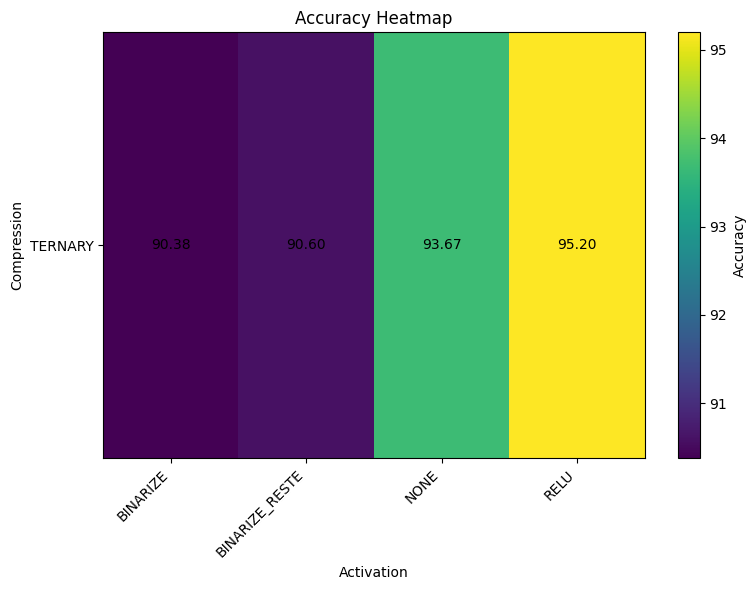

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique compression and activation names
compressions = sorted(set(d['compression'] for d in data))
activations = sorted(set(d['activation'] for d in data))

# Build accuracy matrix
heatmap = np.zeros((len(compressions), len(activations)))
for i, comp in enumerate(compressions):
    for j, act in enumerate(activations):
        accs = [d['accuracy'] for d in data if d['compression'] == comp and d['activation'] == act]
        heatmap[i, j] = np.mean(accs) if accs else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

# Set axis labels
ax.set_xticks(np.arange(len(activations)))
ax.set_yticks(np.arange(len(compressions)))
ax.set_xticklabels(activations, rotation=45, ha='right')
ax.set_yticklabels(compressions)

# Add numbers to each cell
for i in range(len(compressions)):
    for j in range(len(activations)):
        value = heatmap[i, j]
        if not np.isnan(value):
            ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="w" if value < np.nanmax(heatmap)/2 else "black")

# Add colorbar
plt.colorbar(im, ax=ax, label='Accuracy')

ax.set_xlabel('Activation')
ax.set_ylabel('Compression')
ax.set_title('Accuracy Heatmap')
plt.tight_layout()
plt.show()


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7931e902c750>


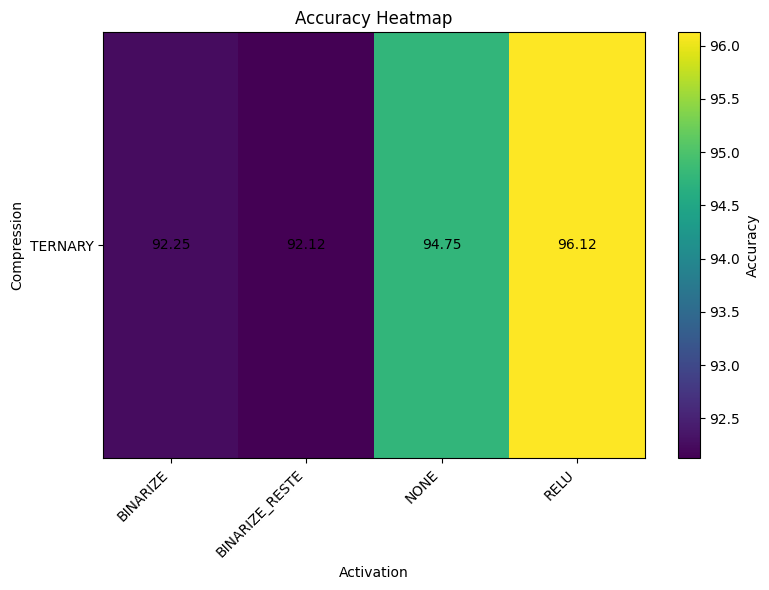

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique compression and activation names
compressions = sorted(set(d['compression'] for d in data))
activations = sorted(set(d['activation'] for d in data))

# Build accuracy matrix
heatmap = np.zeros((len(compressions), len(activations)))
for i, comp in enumerate(compressions):
    for j, act in enumerate(activations):
        accs = [d['accuracy'] for d in data if d['compression'] == comp and d['activation'] == act]
        heatmap[i, j] = max(accs) if accs else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

# Set axis labels
ax.set_xticks(np.arange(len(activations)))
ax.set_yticks(np.arange(len(compressions)))
ax.set_xticklabels(activations, rotation=45, ha='right')
ax.set_yticklabels(compressions)

# Add numbers to each cell
for i in range(len(compressions)):
    for j in range(len(activations)):
        value = heatmap[i, j]
        if not np.isnan(value):
            ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="w" if value < np.nanmax(heatmap)/2 else "black")

# Add colorbar
plt.colorbar(im, ax=ax, label='Accuracy')

ax.set_xlabel('Activation')
ax.set_ylabel('Compression')
ax.set_title('Accuracy Heatmap')
plt.tight_layout()
plt.show()
